# Using NumbaPro

This IPython notebook illustrates how to use [NumbaPro](http://docs.continuum.io/numbapro/). It illustrates the use of CUDA in Python by generating the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) and is based on [this NumbaPro Mandelbrot example](http://nbviewer.ipython.org/gist/harrism/f5707335f40af9463c43).

First import the required Python libraries:

In [1]:
# Python imports
import numpy as np  # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# import a timer
from timeit import default_timer as timer

## Generate Mandelbrot set on CPU

Generate the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) and show the plot with the real dimension of the complex number on the x-axis, and the imaginary dimension on the y-axis.

The `mandel` function performs the Mandelbrot set calculation for a given (x,y) position on the imaginary plane (real, imaginary). It returns the number of iterations before the computation diverges.

The `create_fractal` function iterates over all the pixels in the image, computing the complex coordinates from the pixel coordinates, and calls the `mandel` function at each pixel. The return value of `mandel` is used to color the pixel.

In  this example a 1024x1024 pixel image of the Mandelbrot set between -2 and 1 on the real axis and -1 and 1 on the imaginary axis is generated. This image is stored as a numpy array of bytes. `create_fractal` is called to fill the image with the correct color values.

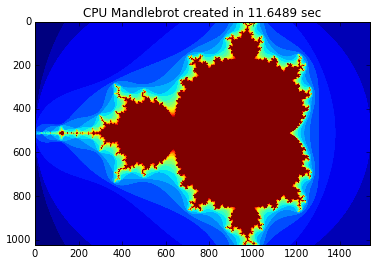

In [2]:
def mandel(x, y, max_iters):
    """
    Given the real (x) and imaginary parts (y) of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)  # Initial complex number
    z = 0.0j  # Complex number that will follow the mandelbrot iteration
    # Perform the mandelbrot iteration until divergence (>=4)
    # c, c² + c, (c²+c)² + c, ((c²+c)²+c)² + c, (((c²+c)²+c)²+c)² + c, ...)
    for i in range(max_iters):
        z = z*z + c  # z² + c
        if (z.real*z.real + z.imag*z.imag) >= 4:  # abs(z) >= 4
            return i
    return max_iters

def create_fractal(min_x, max_x, min_y, max_y, image, max_iters):
    """
    Create the Mandelbrot fractal between min_x + min_y*j and max_x + max_y*j.
    The maximum iterations to detect divergence are max_iters.
    The resulting pixels are stored in image.
    """
    height = image.shape[0]
    width = image.shape[1]
    # Set the size of the pixel on the complex plane
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height   
    # Calcule the value of each pixel
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            # The color depends upon the number of iterations untill divergence
            color = mandel(real, imag, max_iters)
            # Set the pixel color
            image[y, x] = color

# Initialise the image with zero values
image = np.zeros((1024, 1536), dtype = np.uint8)

# Compute the fractal and time the computation
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

# Plot the resulting fractal
plt.imshow(image)
plt.title('CPU Mandlebrot created in {:.4f} sec'.format(dt))
plt.show()

## Generate Mandelbrot set on GPU

To run the CUDA version of the Mandelbrot set the `cuda` library from the `numbapro` module needs to be imported and the functions need to be converted to run on the GPU.

In [3]:
# Import numbapro
import numbapro 
from numbapro import cuda
from numba import *

# See if GPU is present
print "Running on GPU:", cuda.get_current_device()

Running on GPU: <CUDA device 0 'Tesla K40c'>


### CUDA JIT

NumbaPro provides a just in time (JIT) compiler to compile certain parts of Python code to CUDA. The `mandel` function can be wrapped by calling `cuda.jit` on the function, providing it with the return type and the argument types, and specifying `device=True` to indicate that this is a function that will run on the GPU device.

In [4]:
# Wrap the 'mandel' function in a cuda.jit wrapper so it can be ran on the GPU.
mandel_gpu = cuda.jit(restype=uint32, argtypes=[f8, f8, uint32], device=True)(mandel)

### CUDA Kernel

In CUDA, a [kernel](http://numba.pydata.org/numba-doc/dev/cuda/kernels.html) is a function that can run in parallel using many threads on the device. A kernel function that can compute the Mandelbrot set can be build with the help of the `@cuda.jit` function decorator. Using this decorator will enable your function to run on the GPU and will give you access to certain CUDA thread variables.  
In this example the [`cuda.grid`](http://docs.continuum.io/numbapro/CUDAJit.html#thread-identity-by-cuda-intrinsics) function is used to generate the x and y position value of the pixel in the thread that is responsible for processing this pixel. Each thread will get a different x and y position so that all pixels are processed in parallel. Because the positions generated are independent of the underlying image the computation needs to be limited by using `if x < width and y < height:` to only process the pixels in the image.

In [5]:
@cuda.jit(argtypes=[f8, f8, f8, f8, uint8[:,:], uint32])
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
    """
    Define a CUDA kernel that can be ran for each pixel in parallel.
    Create the Mandelbrot fractal between min_x + min_y*j and max_x + max_y*j.
    The maximum iterations to detect divergence are max_iters.
    The resulting pixels are stored in image.
    """
    height = image.shape[0]
    width = image.shape[1]
    # Set the size of the pixel on the complex plane
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    # Define the x and y pixels for which to generate the color
    x,y = cuda.grid(2)
    # Only generate the color for the pixels within the image
    if x < width and y < height:
        real = min_x + x * pixel_size_x
        imag = min_y + y * pixel_size_y
        # Set the pixel color
        image[y, x] = mandel_gpu(real, imag, iters)

### CUDA Device Memory
The CUDA kernel must operate on data stored on the GPU. NumbaPro provides the `cuda.to_device()` function to copy a Numpy array to the GPU. The return value (d_image) is a CUDA array, and provides the `to_host()` function to copy the array back from GPU to CPU memory.


### Launching CUDA kernels
Launching a CUDA kernel creates a grid of threads that all execute the kernel function. All threads in a grid execute the same kernel function, they rely on unique coordinates provided by `cuda.grid` to distinguish themselves from each other and to identify the appropriate portion of the data to process.

These threads are organized into a two-level hierarchy using unique coordinates, called blockId and threadId (abstracted away by `cuda.grid`). At the top level of the hierarchy, a grid is organized as a two dimensional array of blocks. To launch a kernel on the GPU, the size of each thread block and the size of each block must be configured. Threads are organized in blocks. And a block of threads is executed by a multiprocessing unit.

For a 2D image calculation like the Mandelbrot set, we use a 2D grid of 2D blocks. In this example we use 1 block with a grid dimension of 1536 by 1024. If running your own examples more care should be taken into initilizing the blocks and thread grids. You can learn more about CUDA thread grids and blocks [here](https://courses.engr.illinois.edu/ece498al/textbook/Chapter3-CudaThreadingModel.pdf).

The kernel can then be called by calling `mandel_kernel` with the grid and block dimensions and the parameters:

    mandel_kernel[griddim, blockdim](...)

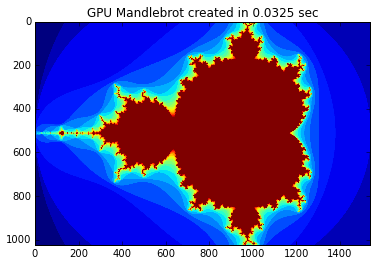

In [6]:
# Initialise the image with zero values
gimage = np.zeros((1024, 1536), dtype = np.uint8)
# Initialise the block and grid dimensions used by CUDA
# blockdim = (32, 32)
# griddim = (64,64)
blockdim = (1, 1)
griddim = (1536,1024)

# Compute the fractal and time the computation
start = timer()
d_image = cuda.to_device(gimage) # Copy the image to the GPU memory
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()# Retreive the image from the GPU memory
dt = timer() - start

# Plot the resulting fractal
plt.imshow(gimage)
plt.title('GPU Mandlebrot created in {:.4f} sec'.format(dt))
plt.show()

The running time to generate the images are put in the title of the images. Notice that the GPU example runs much faster than the CPU example.


For more information on Python CUDA programming please check out the following links:

* [NumbaPro](http://docs.continuum.io/numbapro/)
* [NumbaPro Quickstart](http://docs.continuum.io/numbapro/quickstart.html)
* [Numba for CUDA GPUs documentation](http://numba.pydata.org/numba-doc/dev/cuda/index.html)
* [Introduction to Python GPU Programming with Numba and NumbaPro](https://github.com/ContinuumIO/numbapro-examples/blob/master/webinars/2014_06_17/intro_to_gpu_python.ipynb)
* [Mandelbrot example used as basis for this notebook](http://nbviewer.ipython.org/gist/harrism/f5707335f40af9463c43)
* [Monte Carlo example](http://nbviewer.ipython.org/gist/harrism/835a8ca39ced77fe751d)